In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer

df = pd.read_csv("data/comments_df_11-4-2022.csv")
df.head()

Video Id                                               text  \
0  DOtPOfeyJ4Q  Don't send it back. This video is a gem. Bro, ...   
1  DOtPOfeyJ4Q  Hes not scamming his sister probably got it fo...   
2  DOtPOfeyJ4Q  He offered your money back definitely not a sc...   
3  DOtPOfeyJ4Q  Isn’t it hard authenticate a signature. If Kob...   
4  DOtPOfeyJ4Q  He answered the phone, definitely not trying t...   

                   time          displayID                        id  
0  2022-11-04T15:41:35Z         Tim Gibson  UC8DCyaImyGP2jrJOdD64Efg  
1  2022-11-04T15:04:13Z  The guy who asked  UCNijoEJw5z3p4689tey5oYw  
2  2022-11-04T14:57:57Z              F.B.I  UCXbuhDqmdm_M8UEOrQ77w6w  
3  2022-11-04T14:54:47Z      Olti Hajdaraj  UCPOYMbZKAIN39YFsvMTZ-Uw  
4  2022-11-04T14:49:10Z             Jordan  UCga1Isau1iPAlrezA6xoYSQ

In [5]:
df.rename({'text' : 'comment'} , axis = 1 , inplace = True)

In [10]:
df.dropna(inplace = True)
df.shape

(58553, 5)

## Analyzing Comment length

In [11]:
def comment_length(comment):
    return len(comment.split(' '))

df['comment_length'] = df['comment'].apply(comment_length)
df.head()

Video Id                                            comment  \
0  DOtPOfeyJ4Q  Don't send it back. This video is a gem. Bro, ...   
1  DOtPOfeyJ4Q  Hes not scamming his sister probably got it fo...   
2  DOtPOfeyJ4Q  He offered your money back definitely not a sc...   
3  DOtPOfeyJ4Q  Isn’t it hard authenticate a signature. If Kob...   
4  DOtPOfeyJ4Q  He answered the phone, definitely not trying t...   

                   time          displayID                        id  \
0  2022-11-04T15:41:35Z         Tim Gibson  UC8DCyaImyGP2jrJOdD64Efg   
1  2022-11-04T15:04:13Z  The guy who asked  UCNijoEJw5z3p4689tey5oYw   
2  2022-11-04T14:57:57Z              F.B.I  UCXbuhDqmdm_M8UEOrQ77w6w   
3  2022-11-04T14:54:47Z      Olti Hajdaraj  UCPOYMbZKAIN39YFsvMTZ-Uw   
4  2022-11-04T14:49:10Z             Jordan  UCga1Isau1iPAlrezA6xoYSQ   

   comment_length  
0              45  
1              17  
2              26  
3              21  
4              13

In [13]:
df.shape

(58553, 6)

In [15]:
# Finding the 95th percentile for comment length
comment_len_95_percentile = int(np.percentile(df.comment_length , 95))
comment_len_95_percentile

43

### Getting rid of comments longer than 95th percentile

In [16]:
df = df[df['comment_length'] <= comment_len_95_percentile]
df.shape

(55709, 6)

<AxesSubplot:xlabel='comment_length'>

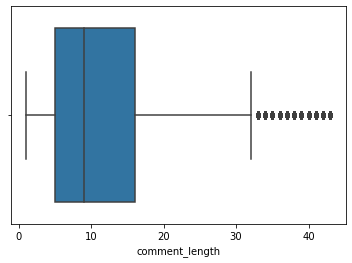

In [17]:
sns.boxplot(x = 'comment_length' , data = df)

## Predicting Sentiment and confidence scores

In [18]:
pipe = pipeline(model = 'cardiffnlp/twitter-roberta-base-sentiment-latest')
pipe.tokenizer.model_max_length=256

Downloading:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
from tqdm import tqdm

comments_list = df.comment.tolist()


sentiment_dicts = [] 

for comment in tqdm(comments_list , total = len(comments_list)):
    try:
        sentiment_dicts.append(pipe(comment))
    except:
        sentiment_dicts.append([{'label' : 'Not Provided', 'score': 'Not Provided'}])
        print(comment)

  9%|██████▊                                                                      | 4954/55709 [02:53<30:01, 28.17it/s]

Me: *makes Nokia spinner*
FBI:  W̴͔̏̕E̵̪͐̌̕ͅ W̴͔̏̕A̶̤͍̟̲͓͕͍̼͕͎̽́̒̇͝N̶͎̫̉̍͘͝T̷̢̧͎̤̗͙̜͓̽͊ͅͅ Y̸̢̨̭̟͍̫͉͊O̸̜͉̹̳̎͒̎̄͘͘͝Ù̸̺̓̀̓͒͑R̶̨̨̖̬̹̥̜̠͎̺̍͐̂ L̸̼̞̰͘O̸̜͉̹̳̎͒̎̄͘͘͝C̸̢̱̗̟̍͗̈́̆͗͒͊̑͘͜A̶̤͍̟̲͓͕͍̼͕͎̽́̒̇͝T̷̢̧͎̤̗͙̜͓̽͊ͅͅĮ̴̧̝͔͍͖͇̹̗̅͆̈́̈́̒̕O̸̜͉̹̳̎͒̎̄͘͘͝N̶͎̫̉̍͘͝ R̶̨̨̖̬̹̥̜̠͎̺̍͐̂Į̴̧̝͔͍͖͇̹̗̅͆̈́̈́̒̕G̶̢̨̖͚̜̺̭̥̭͓̾̒̃̃̈̏͋͝H̸̪͊̒T̷̢̧͎̤̗͙̜͓̽͊ͅͅ N̶͎̫̉̍͘͝O̸̜͉̹̳̎͒̎̄͘͘͝W̴͔̏̕


 97%|██████████████████████████████████████████████████████████████████████████  | 54271/55709 [36:22<00:54, 26.35it/s]

📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸


100%|████████████████████████████████████████████████████████████████████████████| 55709/55709 [37:23<00:00, 24.83it/s]


In [26]:
print(pipe(df.loc[1 , 'comment']))

[{'label': 'Neutral', 'score': 0.6471040844917297}]


In [35]:
# The pipeline returns a list so I will need to unpack each list returned
sentiment_dicts_use = [sentiment[0] for sentiment in sentiment_dicts]
sentiment_dicts_use[0]

{'label': 'Neutral', 'score': 0.6471040844917297}

In [41]:
# Bringing label and confidence score into the dataframe
df['label'] = [sentiment['label'] for sentiment in sentiment_dicts_use]
df['score'] = [sentiment['score'] for sentiment in sentiment_dicts_use]

# Dropping the 2 comments that were edge cases
df = df[df['label'] != 'Not Provided']

df.head()
print(df.shape)

(55707, 8)


In [72]:
df.to_csv('data/all_comments_with_sentiment_scores.csv')

## Do longer comments have a higher confidence?

Text(0.5, 1.0, 'Count by Comment Length')

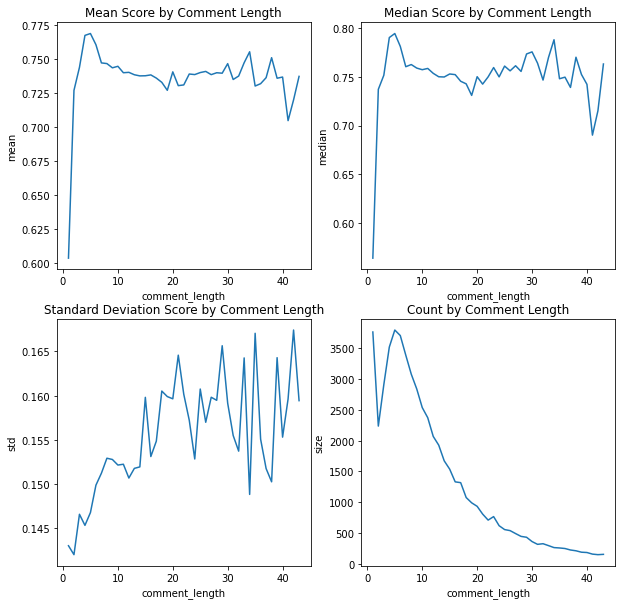

In [70]:
# Do longer comments have a higher confidence?
grouped_comment_length = df.groupby('comment_length')['score'].agg(['mean' , 'median' , 'std' , 'size'])
#print(grouped_comment_length['mean'])

# Plotting
fig , ax = plt.subplots(2 , 2 , figsize = (10 , 10))

sns.lineplot(x = grouped_comment_length.index , y = grouped_comment_length['mean'] ,  ax = ax[0][0]).set_title('Mean Score by Comment Length')
sns.lineplot(x = grouped_comment_length.index , y = grouped_comment_length['median'] ,  ax = ax[0][1]).set_title('Median Score by Comment Length')
sns.lineplot(x = grouped_comment_length.index , y = grouped_comment_length['std'] ,  ax = ax[1][0]).set_title('Standard Deviation Score by Comment Length')
sns.lineplot(x = grouped_comment_length.index , y = grouped_comment_length['size'] ,  ax = ax[1][1]).set_title('Count by Comment Length')

## Confidence by sentiment

<AxesSubplot:xlabel='score', ylabel='label'>

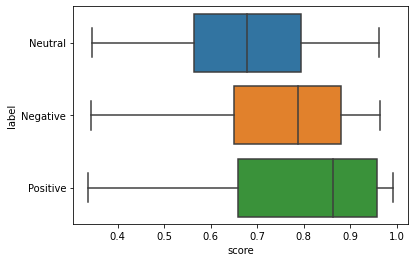

In [73]:
sns.boxplot(x = 'score' , y = 'label' , data = df)

In [74]:
df.label.value_counts()

Neutral     22920
Negative    20197
Positive    12590
Name: label, dtype: int64

The median confidence score for Positive comments is the highest while the model is less confident about its Neutral predictions. The distributions of scores for both Positive and Negative comments are skewed to the left. Negative commments are the most common in this dataset.

## Diving deeper into the comment text

In [2]:
import pandas as pd
df = pd.read_csv('data/all_comments_with_sentiment_scores_weighted.csv')
df.drop(['Unnamed: 0.1' ,'Unnamed: 0' ], axis =1 , inplace = True)
df['comment'].head()

0    Hes not scamming his sister probably got it fo...
1    He offered your money back definitely not a sc...
2    Isn’t it hard authenticate a signature. If Kob...
3    He answered the phone, definitely not trying t...
4    The seller has a legit point tho. At the end o...
Name: comment, dtype: object

In [3]:
df.shape

(55707, 10)

In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
nltk.download('wordnet')
nltk.download('omw-1.4')
#from emot.emo_unicode import UNICODE_EMOJI


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\salaz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\salaz\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [6]:
# Defining Stopwords
stop_words = list(stopwords.words('english'))
other_stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", 
                   "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself",
                   "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", 
                   "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", 
                   "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", 
                   "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", 
                   "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", 
                   "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how",
                   "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not",
                   "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", 
                   "now",'anyone','today','yesterday','day', 'already' , 'the' , 'he', 'got', 'it' , 'isn' , 'video']
letters = list(string.ascii_lowercase)

stop_words = stop_words + other_stop_words + letters

In [7]:
def preprocess_comment(comment):
    comment = comment.lower()
    comment_tokens = word_tokenize(comment)
    filtered_tokens = [word for word in comment_tokens if word not in stop_words]
    filtered_tokens = [word for word in comment_tokens if word.isalpha()]
    # Removing Punctuation
    filtered_tokens = [word for word in filtered_tokens if word not in string.punctuation]
    # Lemmatize the words
    WNL = WordNetLemmatizer()
    lemma_filtered_tokens = [WNL.lemmatize(w) for w in filtered_tokens]
    return " ".join(lemma_filtered_tokens)

In [8]:
df['processed_comment'] = df['comment'].apply(preprocess_comment)

In [9]:
df.head()

Video Id                                            comment  \
0  DOtPOfeyJ4Q  Hes not scamming his sister probably got it fo...   
1  DOtPOfeyJ4Q  He offered your money back definitely not a sc...   
2  DOtPOfeyJ4Q  Isn’t it hard authenticate a signature. If Kob...   
3  DOtPOfeyJ4Q  He answered the phone, definitely not trying t...   
4  DOtPOfeyJ4Q  The seller has a legit point tho. At the end o...   

                   time          displayID                        id  \
0  2022-11-04T15:04:13Z  The guy who asked  UCNijoEJw5z3p4689tey5oYw   
1  2022-11-04T14:57:57Z              F.B.I  UCXbuhDqmdm_M8UEOrQ77w6w   
2  2022-11-04T14:54:47Z      Olti Hajdaraj  UCPOYMbZKAIN39YFsvMTZ-Uw   
3  2022-11-04T14:49:10Z             Jordan  UCga1Isau1iPAlrezA6xoYSQ   
4  2022-11-04T14:44:37Z            AkMac11  UCXOWvLzEwtlUubgZhXJI-Hw   

   comment_length     label     score  sentiment_map  weighted_sentiment  \
0              17   Neutral  0.647104            0.2            0.129421   
1              26   Neutral  0.533190            0.2            0.106638   
2              21  Negative  0.509651           -1.0           -0.509651   
3              13   Neutral  0.483931            0.2            0.096786   
4              17   Neutral  0.628328            0.2            0.125666   

                                   processed_comment  
0  he not scamming his sister probably got it for...  
1  he offered your money back definitely not a sc...  
2  isn t it hard authenticate a signature if kobe...  
3  he answered the phone definitely not trying to...  
4  the seller ha a legit point tho at the end of ...

In [10]:
df_positive = df[df['label'] == 'Positive']
df_positive_tweets_long_string = " ".join(df_positive['processed_comment'].tolist())

In [11]:
df_positive_tweets_long_string

'still a cool piece nonetheless i would drop a few band for that ngl he is either real or really good at what he doe but i would actually feel like he wa real and i would keep the ball he seems legit ngl i have a feeling it real now the guy if pretty chill and even asking if he want to give it back after watching karl jobst talk about video game authentication i can see what the seller is saying to be some what ture karl jobst doe a fantastic video on how authenticator took advantage of the video game market bernie madoff always offered to give people their money back it sure seems way more legit when he offered to return the ball good sale tactic or legit oh the humanity help me me seen i won the macbook book and trying to get ahold of stevie much love everyone loved the attitude of guy what a pleasant seller that real customer service i believe him you can tell strait away he being honest capped off with an offer to refund you the money that rare keep it try to get shaq to sign it fo

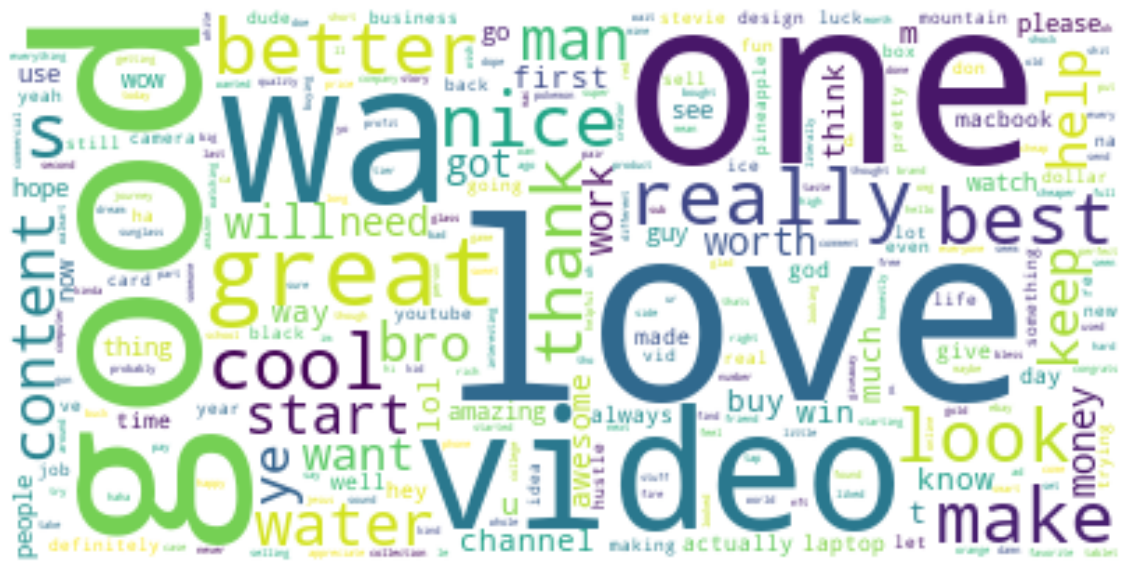

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

positive_wc = WordCloud(collocations = False,max_words=400 , background_color = 'white').generate(df_positive_tweets_long_string)

plt.figure(figsize = (20, 20))
plt.imshow(positive_wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [16]:
df_negative= df[df['label'] == 'Negative']
df_negative_tweets_long_string = " ".join(df_negative['processed_comment'].tolist())
df_negative_tweets_long_string

'isn t it hard authenticate a signature if kobe is signing ton of stuff he would mess up from time to time the fact they are answering the phone speaking to you and not yelling and being defensive tell me it most likely real but like he said send it back this dude video are pretty well made but his side hustle couldn t be any dumber is not worth it tho a ball so this prompted me to do some research into beckett ai a great company from what i can find even worse than psa and those people are something else bro you milking this autographed shit did not expect that prolly genuine guy is either a master the story a hundred time or is telling the truth occam s razor say it legit and beckett is po which i already believed tbh how would they witness an autograph if kobe been dead bro make no sense seems fake let just say if they were trying to scam you it take ball to pick up your call and talk to you about it while also offering you to return it lol if it can t be authenticated then it may a

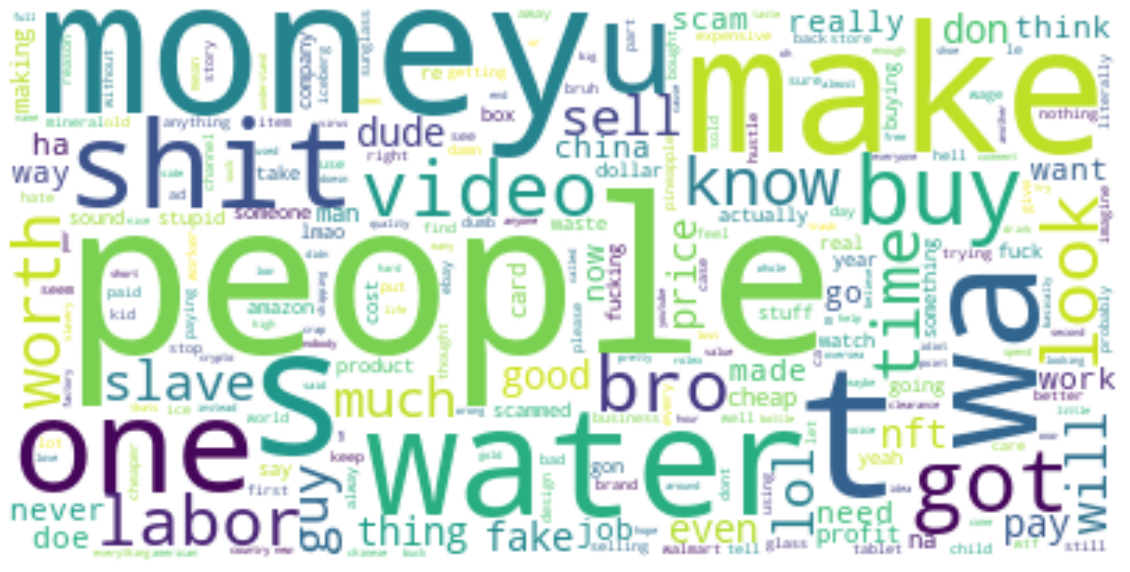

In [17]:
negative_wc = WordCloud(collocations = False,max_words=400 , background_color = 'white').generate(df_negative_tweets_long_string)

plt.figure(figsize = (20, 20))
plt.imshow(negative_wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## Aggregating by Video Id

### Mapping Sentiment to integers / Creating weighted sentiment

In order to aggregate across videos, I decided to map 'Positive' to 1, 'Negative' to -1, 'Neutral' to 0.2. I will scale these by the confidence provided by the model (this will scale down less confident predictions) and then calculate the mean/median/std of the sentiment scores for each video. 

In [78]:
df = pd.read_csv('data/all_comments_with_sentiment_scores.csv')

mapping_func = {'Positive' : 1,
               'Negative' : -1 ,
               'Neutral' : 0.2}

df['sentiment_map'] = df['label'].map(mapping_func)
df.head()

Unnamed: 0     Video Id                                            comment  \
0           1  DOtPOfeyJ4Q  Hes not scamming his sister probably got it fo...   
1           2  DOtPOfeyJ4Q  He offered your money back definitely not a sc...   
2           3  DOtPOfeyJ4Q  Isn’t it hard authenticate a signature. If Kob...   
3           4  DOtPOfeyJ4Q  He answered the phone, definitely not trying t...   
4           5  DOtPOfeyJ4Q  The seller has a legit point tho. At the end o...   

                   time          displayID                        id  \
0  2022-11-04T15:04:13Z  The guy who asked  UCNijoEJw5z3p4689tey5oYw   
1  2022-11-04T14:57:57Z              F.B.I  UCXbuhDqmdm_M8UEOrQ77w6w   
2  2022-11-04T14:54:47Z      Olti Hajdaraj  UCPOYMbZKAIN39YFsvMTZ-Uw   
3  2022-11-04T14:49:10Z             Jordan  UCga1Isau1iPAlrezA6xoYSQ   
4  2022-11-04T14:44:37Z            AkMac11  UCXOWvLzEwtlUubgZhXJI-Hw   

   comment_length     label     score  sentiment_map  
0              17   Neutral  0.647104            0.2  
1              26   Neutral  0.533190            0.2  
2              21  Negative  0.509651           -1.0  
3              13   Neutral  0.483931            0.2  
4              17   Neutral  0.628328            0.2

### Weighted sentiment

In [79]:
df['weighted_sentiment'] = df['sentiment_map'] * df['score']

<AxesSubplot:xlabel='weighted_sentiment', ylabel='Density'>

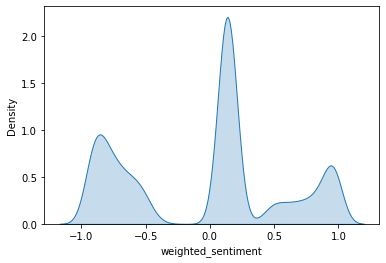

In [86]:
sns.kdeplot(df['weighted_sentiment'] , fill = True)

In [81]:
df.to_csv('data/all_comments_with_sentiment_scores_weighted.csv')

### weighted_sentiment by grouped by video

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data/all_comments_with_sentiment_scores_weighted.csv')
weighted_sentiment_agg_vid = df.groupby('Video Id')['weighted_sentiment'].agg(['mean' , 'median' , 'std'])
weighted_sentiment_agg_vid.reset_index(inplace = True)

In [8]:
weighted_sentiment_agg_vid = pd.DataFrame(weighted_sentiment_agg_vid)
weighted_sentiment_agg_vid

Video Id      mean    median       std
0    -NeMQkXjzLQ -0.066425  0.129703  0.550202
1    -hQCZGiwyUA  0.650249  0.909891  0.383607
2    0FXgNvNDqS8  0.287056  0.166229  0.518681
3    0JqbAZhncZ8 -0.213679 -0.600610  0.658120
4    0gJlInD47gw -0.263380 -0.655285  0.685772
..           ...       ...       ...       ...
179  yYqWz-v9frA -0.048377  0.129137  0.538907
180  ygsO-ExanEM  0.656781  0.916128  0.590811
181  z9MWIpKlhG8 -0.323747 -0.585163  0.560928
182  zKbnMJEpVkk  0.226797  0.150929  0.588072
183  zSyN4pW_tSg  0.364537  0.950150  1.039052

[184 rows x 4 columns]

The next step for further analysis would be to merge this with a dataframe containing more information about the videos.

In [7]:
video_info = pd.read_csv('data/video_info.csv')
video_info.drop('Unnamed: 0' , axis = 1 , inplace = True)
video_info

video_id                                        video_title  \
0    DOtPOfeyJ4Q  Confronting the seller of a questionable Kobe ...   
1    ZrZVTAdSMl8  Do experts think my cheap Kobe autograph is real?   
2    _DcZFOirIDE                          Anyone need a new camera?   
3    JVHboSk65-k  I asked collectors if my cheap Kobe autographs...   
4    nxy-A8auW9U      Unboxing a $400 Kobe autographed ball (real?)   
..           ...                                                ...   
179  G64RvvjWadc  9 Side Hustles That Are Slept On In 2021 ($200...   
180  qlPG818l_Yc  I Tried Dropshipping A Dollar Tree Product (72...   
181  GKgZiqBsxds  Zero To 500k On Facebook In 1 Year | Full Step...   
182  Kxxxtkioncc  I Tried Dropshipping From Scratch (24HR CHALLE...   
183  -hQCZGiwyUA  How I Started A Million Dollar Business From M...   

    upload_date  view_count  like_count  comment_count  
0    2022-11-02      781610       62761            447  
1    2022-11-01      113539        9483             57  
2    2022-11-01       40723        3162           3230  
3    2022-10-31      971564       78562             70  
4    2022-10-28      501415       46803             70  
..          ...         ...         ...            ...  
179  2021-05-27        3058         175              9  
180  2021-04-30        2206          95             10  
181  2021-03-30        1080          81             10  
182  2021-03-10        7339         397             55  
183  2021-02-23        6467         405             37  

[184 rows x 6 columns]

This dataframe contains the **video title , upload_date , view_count , like_count , and total comment count**. Merging the aggregated sentiment data leads to some interesting insights.

## Merging with other video info

In [9]:
video_info_with_sentiment = video_info.merge(right = weighted_sentiment_agg_vid ,how = 'inner'  , left_on = 'video_id' , right_on = 'Video Id')
video_info_with_sentiment.shape

(184, 10)

In [11]:
video_info_with_sentiment.drop('Video Id' , axis = 1 , inplace = True)
video_info_with_sentiment.columns

Index(['video_id', 'video_title', 'upload_date', 'view_count', 'like_count',
       'comment_count', 'mean', 'median', 'std'],
      dtype='object')

In [12]:
video_info_with_sentiment.rename({
    'mean' : 'mean_weighted_sentiment_score',
    'median' : 'median_weighted_sentiment_score',
    'std' : 'std_weighted_sentiment_score'
}, axis = 1 , inplace = True)

video_info_with_sentiment.columns

Index(['video_id', 'video_title', 'upload_date', 'view_count', 'like_count',
       'comment_count', 'mean_weighted_sentiment_score',
       'median_weighted_sentiment_score', 'std_weighted_sentiment_score'],
      dtype='object')

Looking at some of the rows I noticed that many of the earlier videos had fewer comments. Because of this I decided to set a threshold for the number of comments and will not include videos with less than 30 comments in my analysis

In [24]:
num_comments_threshold = video_info_with_sentiment['comment_count'].quantile(0.20)
video_info_with_sentiment = video_info_with_sentiment[video_info_with_sentiment['comment_count'] >= num_comments_threshold]
video_info_with_sentiment.shape

(147, 9)

In [25]:
video_info_with_sentiment.columns

Index(['video_id', 'video_title', 'upload_date', 'view_count', 'like_count',
       'comment_count', 'mean_weighted_sentiment_score',
       'median_weighted_sentiment_score', 'std_weighted_sentiment_score'],
      dtype='object')

## Video Analysis

### Turning the weighted sentiment score into a label

In [26]:
def sentiment_category(sentiment_score):
    if sentiment_score >= 0.1:
        return 'Positive'
    elif sentiment_score <= -0.1:
        return 'Negative'
    else:
        return 'Neutral'

In [29]:
video_info_with_sentiment['sentiment_label'] = video_info_with_sentiment['mean_weighted_sentiment_score'].apply(sentiment_category)

Index(['video_id', 'video_title', 'upload_date', 'view_count', 'like_count',
       'comment_count', 'mean_weighted_sentiment_score',
       'median_weighted_sentiment_score', 'std_weighted_sentiment_score',
       'sentiment_label'],
      dtype='object')

In [33]:
video_info_with_sentiment.columns

Index(['video_id', 'video_title', 'upload_date', 'view_count', 'like_count',
       'comment_count', 'mean_weighted_sentiment_score',
       'median_weighted_sentiment_score', 'std_weighted_sentiment_score',
       'sentiment_label'],
      dtype='object')

In [28]:
video_info_with_sentiment.sentiment_label.value_counts()

Positive    55
Negative    52
Neutral     40
Name: sentiment_label, dtype: int64

In [4]:
video_info_with_sentiment.to_csv('data/video_info_with_sentiment.csv')

In [5]:
video_info_with_sentiment = pd.read_csv('data/video_info_with_sentiment.csv')

In [6]:
import plotly.express as px

fig = px.scatter(video_info_with_sentiment , x = 'comment_count' , y = 'view_count' , color = 'sentiment_label', hover_data = ['video_title' , 'comment_count' , 'upload_date'] , title= 'Like Count and View Count Scatter for All Videos')
fig.show()

### Visualizations

In [7]:
fig = px.scatter(video_info_with_sentiment , x = 'mean_weighted_sentiment_score' , y = 'view_count' , color = 'sentiment_label', hover_data = ['video_title' , 'comment_count' , 'upload_date' , 'video_id'] , title= 'Mean Weighted Sentiment Score and View Count Scatter for All Videos')
fig.show()

In [40]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Video Id', 'comment', 'time',
       'displayID', 'id', 'comment_length', 'label', 'score', 'sentiment_map',
       'weighted_sentiment'],
      dtype='object')

<AxesSubplot:xlabel='weighted_sentiment', ylabel='Density'>

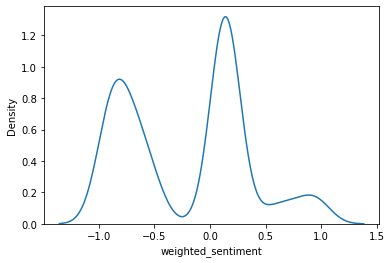

In [41]:
import seaborn as sns

sns.kdeplot(df[df['Video Id'] == 'auxv8xyea9c']['weighted_sentiment'])

<AxesSubplot:xlabel='weighted_sentiment', ylabel='Density'>

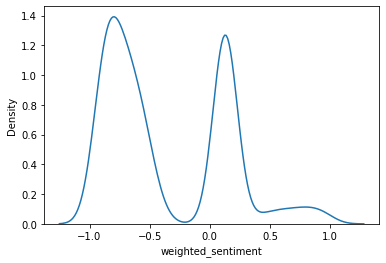

In [42]:
sns.kdeplot(df[df['Video Id'] == 'MeR0neyhrEw']['weighted_sentiment'])

<AxesSubplot:xlabel='weighted_sentiment', ylabel='Density'>

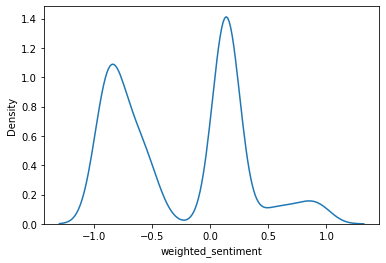

In [43]:
sns.kdeplot(df[df['Video Id'] == 'x7EGS-QEqzA']['weighted_sentiment'])